In [23]:
import copy
import sys
import numpy as np
import pandas as pd


sys.path.append('../') #server per fare l'import di file in un'altra directory sullo stesso "livello"
from src.NeuralNetwork import Layer, NeuralNetwork, calculate_total_error
from src.function import IdentityFunction, SigmoideFunction, ReLuFunction
from matplotlib import pyplot as plt
from src.load_ds import load_monks_1_train

In [24]:
learning_rate = 0.01
regularization_term = 0
epoch = 50

In [25]:
target_inputs, target_outputs = load_monks_1_train()

# PyTorch

In [26]:
# Torch model
import torch

# to tensors (float)
target_inputs_torch = torch.tensor(target_inputs, dtype=torch.float)
target_outputs_torch = torch.tensor(target_outputs, dtype=torch.float)

train_errors = []


class SimpleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(17, 5, bias=True)
        self.linear2 = torch.nn.Linear(5, 4, bias=True)
        self.linear3 = torch.nn.Linear(4, 1, bias=True)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)  # apply ReLU activation function

        x = self.linear2(x)
        x = torch.relu(x)  # apply ReLU activation function

        x = self.linear3(x)
        x = torch.sigmoid(x)

        return x

    # funzione loss usata nel corso
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, target_output, output_nn):
        error_vector = (target_output - output_nn)**2 / 2
        error_total = error_vector.sum()
        return error_total

# funzione loss usata nel corso
class CustomError(torch.nn.Module):
    def __init__(self):
        super(CustomError, self).__init__()

    def forward(self, target_output, output_nn):
        error_vector = (target_output - output_nn)**2
        error_total = error_vector.sum()
        return error_total

model = SimpleModel()
# define the loss function
loss_fn = CustomLoss()
error_fn = CustomError()


weights1 = np.matrix(model.linear1.weight.detach().numpy()).copy()
weights2 = np.matrix(model.linear2.weight.detach().numpy()).copy()
weights3 = np.matrix(model.linear3.weight.detach().numpy()).copy()

error_history_torch = []
for _ in range(epoch):
    # Define the loss function
    loss_fn = CustomLoss()
    error_fn = CustomError()

    y_pred = model(target_inputs_torch)
    loss = loss_fn(target_output = target_outputs_torch, output_nn = y_pred)

    l2_reg = 0
    for param in model.parameters():
        l2_reg += (param ** 2).sum()

    loss = loss + regularization_term*l2_reg

    loss.backward()

    # Manually update the weights
    with torch.no_grad():
        for param in model.parameters():
            param += -(learning_rate * param.grad)

    y_pred = model(target_inputs_torch)
    error = error_fn(target_output = target_outputs_torch, output_nn = y_pred)
    error_history_torch.append(error.item())

    model.zero_grad()

# Nostro modello

In [27]:
layer1 = Layer(num_neurons = 5, num_inputs = 17, activation_function = ReLuFunction())
layer2 = Layer(num_neurons = 4, num_inputs = 5, activation_function = ReLuFunction())
layer3 = Layer(num_neurons = 1, num_inputs = 4, activation_function = SigmoideFunction())

layer1.weights = weights1
layer2.weights = weights2
layer3.weights = weights3

neuralNetwork = NeuralNetwork([layer1, layer2, layer3])

deep_copy_layers = copy.deepcopy(neuralNetwork.layers)

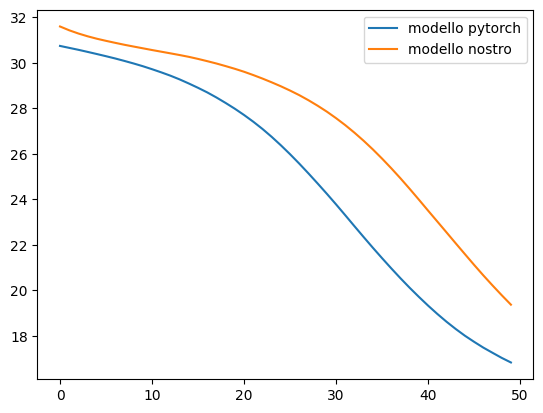

In [28]:
for i in range(len(deep_copy_layers)):
    neuralNetwork.layers[i].weights = deep_copy_layers[i].weights.copy()

error_history = neuralNetwork.train(target_inputs, target_outputs,
                                    epochs = epoch, learning_rate = learning_rate,
                                    regularization_term=0, momentum_term=0)

# error plot
plt.plot(error_history  , label='modello pytorch')
plt.plot(error_history_torch, label='modello nostro')
plt.legend()

In [29]:
output_nn = neuralNetwork.predict(target_inputs)
output_nn = np.matrix(np.where(output_nn >= 0.5, 1, output_nn))
output_nn = np.matrix(np.where(output_nn < 0.5, 0, output_nn))
calculate_total_error(target_output=target_outputs, output_nn=output_nn)

20.0

### Keras

In [30]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import Adam
#
# # Create a model with one hidden layer and one output layer
# model = Sequential()
# model.add(Dense(4, input_dim=17, activation='relu'))
# model.add(Dense(4, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
#
# for layer in model.layers:
#     weights, biases = layer.get_weights()
#     # Set the bias values to zero
#     biases = [np.zeros_like(bias) for bias in biases]
#
# # Create an Adam optimizer with a learning rate of 0.001
# optimizer = Adam(learning_rate=learning_rate)
# model.compile(loss='mean_squared_error', optimizer=optimizer)
# history = model.fit(target_inputs, target_outputs, batch_size=124, epochs=epoch)

In [31]:
# plt.plot(history.history['loss'])

In [32]:
# history.history['loss'][-1]

In [33]:
# output_nn_keras = model.predict(target_inputs)
# output_nn_keras = np.matrix(np.where(output_nn_keras >= 0.5, 1, output_nn_keras))
# output_nn_keras = np.matrix(np.where(output_nn_keras < 0.5, 0, output_nn_keras))
# calculate_total_error(target_output=target_outputs, output_nn=output_nn_keras)